In [5]:
# Untitled 5 but using a different architecture and augmentations
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.utils import shuffle
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from kerastuner.tuners import RandomSearch

# Setting random seeds to reduce the amount of randomness in the neural net weights and results
# The results may still not be exactly reproducible
np.random.seed(42)
tf.random.set_seed(42)

C:\Users\ndhu2\AppData\Local\Temp\ipykernel_28104\1215708746.py:24: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [8]:
#Load MATLAB file 'imdb.mat' using the scipy.io module.
mat = scipy.io.loadmat('imdb_crop/imdb.mat')

#Display the contents of mat variable
display(mat)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Jan 17 11:30:27 2016',
 '__version__': '1.0',
 '__globals__': [],
 'imdb': array([[(array([[693726, 693726, 693726, ..., 726831, 726831, 726831]]), array([[1968, 1970, 1968, ..., 2011, 2011, 2011]], dtype=uint16), array([[array(['01/nm0000001_rm124825600_1899-5-10_1968.jpg'], dtype='<U43'),
                 array(['01/nm0000001_rm3343756032_1899-5-10_1970.jpg'], dtype='<U44'),
                 array(['01/nm0000001_rm577153792_1899-5-10_1968.jpg'], dtype='<U43'),
                 ...,
                 array(['08/nm3994408_rm926592512_1989-12-29_2011.jpg'], dtype='<U44'),
                 array(['08/nm3994408_rm943369728_1989-12-29_2011.jpg'], dtype='<U44'),
                 array(['08/nm3994408_rm976924160_1989-12-29_2011.jpg'], dtype='<U44')]],
               dtype=object), array([[1., 1., 1., ..., 0., 0., 0.]]), array([[array(['Fred Astaire'], dtype='<U12'),
                 array(['Fred Astaire'], dtype='<U12'),

In [9]:
# Convert the data into a pandas dataframe for easier handling and analysis

# Extract the data from the 'imdb' key in the provided data
imdb_data = mat['imdb'][0][0][0]

# Get the number of instances in the data
instances = imdb_data.shape[1]

# Define the column names for the dataframe
columns = ["dob", "photo_taken", "full_path", "gender", "name", "face_location", "face_score", "second_face_score"]

# Create an empty dataframe with the specified columns and number of instances
df = pd.DataFrame(index=range(instances), columns=columns)

# Extract the data from "imdb" key in the loaded data
current_array = mat["imdb"][0][0]

# Assign the values from the current_array to the corresponding columns in the dataframe
for j, column in enumerate(columns[:len(current_array)]):
    df[column] = pd.DataFrame(current_array[j][0])



In [10]:
# 1.  Converting MATLAB datenum values in the 'dob' column of the DataFrame 'df' to exact dates and calculating the corresponding years for 'date_of_birth',
# followed by calculating the age by subtracting 'date_of_birth' from the 'photo_taken' column.
from datetime import datetime, timedelta

def datenum_to_year(datenum):
    epoch = datetime(1, 1, 1)  # Define the epoch as January 1, 0001
    ordinal = int(datenum) + 366  # Adjust for MATLAB datenum offset
    exact_date = datetime.fromordinal(ordinal) + timedelta(days=datenum % 1)  # Add fractional days
    return exact_date.year

# Convert MATLAB datenum values to years and assign the result to the 'date_of_birth' column
df['date_of_birth'] = df['dob'].apply(datenum_to_year)

# 2.  Calculate the age by subtracting 'date_of_birth' from the 'photo_taken' column
df['age'] = df['photo_taken'] - df['date_of_birth']

In [11]:
# 3.  Removing pictures that don't have faces based on the 'face_score' column
df = df.loc[df['face_score'] != -np.inf]

# 4.  Removing duplicate pictures based on the presence of a second face ('second_face_score' is NaN)
df = df.loc[df['second_face_score'].isna()]

# 5.  Removing pictures with age greater than 100 or less than or equal to 0
df = df.loc[df['age'] <= 100]
df = df.loc[df['age'] > 0]

In [12]:
# 6.  Droping rows with missing values in the 'gender' column
df.dropna(subset=['gender'], inplace=True)

# Displaying the value counts of the 'gender' column using value_counts() to understand the distribution of genders in the dataset.
gender_counts = df['gender'].value_counts()
display(gender_counts)

# NOTE: Gender: 1 - Male , 0 - Female

1.0    99875
0.0    81520
Name: gender, dtype: int64

In [13]:
# 7.  Filtering the DataFrame df based on a 'face_score' threshold of 1.5, removing rows with lower-quality face images.
df = df[df['face_score'] >= 1.5]

In [14]:
# 8. Converting each element in the 'full_path' column to a string by using str() and np.squeeze() within a list comprehension,
# the code assigns the resulting string representations to a new 'path' column in the DataFrame.
df['path'] = [str(np.squeeze(i)) for i in df['full_path']]
display(df)

,dob,photo_taken,full_path,gender,name,face_location,face_score,second_face_score,date_of_birth,age,path
3,693726,1968,[01/nm0000001_rm946909184_1899-5-10_1968.jpg],1.0,[Fred Astaire],"[[622.8855056426588, 424.21750383700805, 844.3...",1.872117,NaN,1901,67,01/nm0000001_rm946909184_1899-5-10_1968.jpg
6,702986,2004,[02/nm0000002_rm1346607872_1924-9-16_2004.jpg],0.0,[Lauren Bacall],"[[78.23569406558903, 52.335129377059346, 194.2...",3.479189,NaN,1926,78,02/nm0000002_rm1346607872_1924-9-16_2004.jpg
7,702986,2004,[02/nm0000002_rm1363385088_1924-9-16_2004.jpg],0.0,[Lauren Bacall],"[[64.30867103752385, 64.30867103752385, 207.26...",3.870171,NaN,1926,78,02/nm0000002_rm1363385088_1924-9-16_2004.jpg
12,702986,1974,[02/nm0000002_rm221957120_1924-9-16_1974.jpg],0.0,[Lauren Bacall],"[[3173.144692593433, 401.0408365741791, 4059.1...",4.096431,NaN,1926,48,02/nm0000002_rm221957120_1924-9-16_1974.jpg
13,702986,2007,[02/nm0000002_rm2287049216_1924-9-16_2007.jpg],0.0,[Lauren Bacall],"[[138.80620247948153, 33.92673852953003, 181.1...",3.482030,NaN,1926,81,02/nm0000002_rm2287049216_1924-9-16_2007.jpg
...,...,...,...,...,...,...,...,...,...,...,...
460715,726831,2011,[08/nm3994408_rm73386752_1989-12-29_2011.jpg],0.0,[Jane Levy],"[[161, 161, 448, 448]]",4.801987,NaN,1991,20,08/nm3994408_rm73386752_1989-12-29_2011.jpg
460716,726831,2011,[08/nm3994408_rm744468480_1989-12-29_2011.jpg],0.0,[Jane Levy],"[[300.756, 96.276, 422.592, 218.112]]",2.370091,NaN,1991,20,08/nm3994408_rm744468480_1989-12-29_2011.jpg
460718,726831,2011,[08/nm3994408_rm761245696_1989-12-29_2011.jpg],0.0,[Jane Levy],"[[453.8981431333457, 77.96623712908011, 539.79...",3.845884,NaN,1991,20,08/nm3994408_rm761245696_1989-12-29_2011.jpg
460721,726831,2011,[08/nm3994408_rm943369728_1989-12-29_2011.jpg],0.0,[Jane Levy],"[[144.75225471724875, 126.76472287759263, 305....",4.450725,NaN,1991,20,08/nm3994408_rm943369728_1989-12-29_2011.jpg


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 153626 entries, 3 to 460722
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   dob                153626 non-null  int32  
 1   photo_taken        153626 non-null  uint16 
 2   full_path          153626 non-null  object 
 3   gender             153626 non-null  float64
 4   name               153626 non-null  object 
 5   face_location      153626 non-null  object 
 6   face_score         153626 non-null  float64
 7   second_face_score  0 non-null       float64
 8   date_of_birth      153626 non-null  int64  
 9   age                153626 non-null  int64  
 10  path               153626 non-null  object 
dtypes: float64(3), int32(1), int64(2), object(4), uint16(1)
memory usage: 12.6+ MB


In [16]:
folder_path = 'D:/Users/ndhu2/Classes/Introduction to AI/Project/imdb_crop/crop_part1'  # Replace with the actual folder path

# Step 1: Use os.listdir to get a list of all image filenames in the folder
image_filenames = os.listdir(folder_path)

# Initialize an empty list to store individual DataFrames
dataframes_list = []

# Step 2: Loop through the filenames and extract age and gender information
for filename in image_filenames:
    # Split the filename using underscores to get age, gender, and other parts
    parts = filename.split('_')
    age = int(parts[0])
    gender = int(parts[1])

    # Create the full path to the image file
    image_path = 'crop_part1/'+filename

    # Step 3: Create a DataFrame for the current image and append it to the list
    image_df = pd.DataFrame({'path': [image_path], 'age': [age], 'gender': [gender]})
    dataframes_list.append(image_df)

temp_df = pd.concat(dataframes_list, ignore_index=True)

# Step 4: Concatenate all individual DataFrames into the final DataFrame
df = pd.concat([df, temp_df], ignore_index=True)

# Your DataFrame 'df' now contains the path, age, and gender information of the images
print(df.head())  # Check the first few rows of the DataFrame


        dob  photo_taken                                       full_path  \
0  693726.0       1968.0   [01/nm0000001_rm946909184_1899-5-10_1968.jpg]   
1  702986.0       2004.0  [02/nm0000002_rm1346607872_1924-9-16_2004.jpg]   
2  702986.0       2004.0  [02/nm0000002_rm1363385088_1924-9-16_2004.jpg]   
3  702986.0       1974.0   [02/nm0000002_rm221957120_1924-9-16_1974.jpg]   
4  702986.0       2007.0  [02/nm0000002_rm2287049216_1924-9-16_2007.jpg]   

   gender             name                                      face_location  \
0     1.0   [Fred Astaire]  [[622.8855056426588, 424.21750383700805, 844.3...   
1     0.0  [Lauren Bacall]  [[78.23569406558903, 52.335129377059346, 194.2...   
2     0.0  [Lauren Bacall]  [[64.30867103752385, 64.30867103752385, 207.26...   
3     0.0  [Lauren Bacall]  [[3173.144692593433, 401.0408365741791, 4059.1...   
4     0.0  [Lauren Bacall]  [[138.80620247948153, 33.92673852953003, 181.1...   

   face_score  second_face_score  date_of_birth  age  \


In [17]:
folder_path = 'D:/Users/ndhu2/Classes/Introduction to AI/Project/imdb_crop/UTKFace'  # Replace with the actual folder path

# Step 1: Use os.listdir to get a list of all image filenames in the folder
image_filenames = os.listdir(folder_path)

# Initialize an empty list to store individual DataFrames
dataframes_list = []

# Step 2: Loop through the filenames and extract age and gender information
for filename in image_filenames:
    # Split the filename using underscores to get age, gender, and other parts
    parts = filename.split('_')
    age = int(parts[0])
    gender = int(parts[1])

    # Create the full path to the image file
    image_path = 'UTKFace/'+filename

    # Step 3: Create a DataFrame for the current image and append it to the list
    image_df = pd.DataFrame({'path': [image_path], 'age': [age], 'gender': [gender]})
    dataframes_list.append(image_df)

temp_df = pd.concat(dataframes_list, ignore_index=True)

# Step 4: Concatenate all individual DataFrames into the final DataFrame
df = pd.concat([df, temp_df], ignore_index=True)

# Your DataFrame 'df' now contains the path, age, and gender information of the images
print(df.head())  # Check the first few rows of the DataFrame


        dob  photo_taken                                       full_path  \
0  693726.0       1968.0   [01/nm0000001_rm946909184_1899-5-10_1968.jpg]   
1  702986.0       2004.0  [02/nm0000002_rm1346607872_1924-9-16_2004.jpg]   
2  702986.0       2004.0  [02/nm0000002_rm1363385088_1924-9-16_2004.jpg]   
3  702986.0       1974.0   [02/nm0000002_rm221957120_1924-9-16_1974.jpg]   
4  702986.0       2007.0  [02/nm0000002_rm2287049216_1924-9-16_2007.jpg]   

   gender             name                                      face_location  \
0     1.0   [Fred Astaire]  [[622.8855056426588, 424.21750383700805, 844.3...   
1     0.0  [Lauren Bacall]  [[78.23569406558903, 52.335129377059346, 194.2...   
2     0.0  [Lauren Bacall]  [[64.30867103752385, 64.30867103752385, 207.26...   
3     0.0  [Lauren Bacall]  [[3173.144692593433, 401.0408365741791, 4059.1...   
4     0.0  [Lauren Bacall]  [[138.80620247948153, 33.92673852953003, 181.1...   

   face_score  second_face_score  date_of_birth  age  \


In [18]:
display(df)

,dob,photo_taken,full_path,gender,name,face_location,face_score,second_face_score,date_of_birth,age,path
0,693726.0,1968.0,[01/nm0000001_rm946909184_1899-5-10_1968.jpg],1.0,[Fred Astaire],"[[622.8855056426588, 424.21750383700805, 844.3...",1.872117,NaN,1901.0,67,01/nm0000001_rm946909184_1899-5-10_1968.jpg
1,702986.0,2004.0,[02/nm0000002_rm1346607872_1924-9-16_2004.jpg],0.0,[Lauren Bacall],"[[78.23569406558903, 52.335129377059346, 194.2...",3.479189,NaN,1926.0,78,02/nm0000002_rm1346607872_1924-9-16_2004.jpg
2,702986.0,2004.0,[02/nm0000002_rm1363385088_1924-9-16_2004.jpg],0.0,[Lauren Bacall],"[[64.30867103752385, 64.30867103752385, 207.26...",3.870171,NaN,1926.0,78,02/nm0000002_rm1363385088_1924-9-16_2004.jpg
3,702986.0,1974.0,[02/nm0000002_rm221957120_1924-9-16_1974.jpg],0.0,[Lauren Bacall],"[[3173.144692593433, 401.0408365741791, 4059.1...",4.096431,NaN,1926.0,48,02/nm0000002_rm221957120_1924-9-16_1974.jpg
4,702986.0,2007.0,[02/nm0000002_rm2287049216_1924-9-16_2007.jpg],0.0,[Lauren Bacall],"[[138.80620247948153, 33.92673852953003, 181.1...",3.482030,NaN,1926.0,81,02/nm0000002_rm2287049216_1924-9-16_2007.jpg
...,...,...,...,...,...,...,...,...,...,...,...
187109,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,9,UTKFace/9_1_3_20161220222856346.jpg.chip.jpg
187110,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,9,UTKFace/9_1_3_20170104222949455.jpg.chip.jpg
187111,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,9,UTKFace/9_1_4_20170103200637399.jpg.chip.jpg
187112,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,9,UTKFace/9_1_4_20170103200814791.jpg.chip.jpg


In [19]:
# Convert the gender values to integers before grouping
df['gender'] = df['gender'].astype(int)

print(df.dtypes)

dob                  float64
photo_taken          float64
full_path             object
gender                 int32
name                  object
face_location         object
face_score           float64
second_face_score    float64
date_of_birth        float64
age                    int64
path                  object
dtype: object


In [20]:

# Print unique values in the 'gender' column
gender_counts = df['gender'].value_counts()
print(gender_counts)

# Define the correct gender values that you want to keep
valid_genders = [0, 1]

# Filter the DataFrame to keep only the rows with valid gender values
df = df[df['gender'].isin(valid_genders)]

gender_counts = df['gender'].value_counts()
print(gender_counts)


1    98622
0    88491
3        1
Name: gender, dtype: int64
1    98622
0    88491
Name: gender, dtype: int64


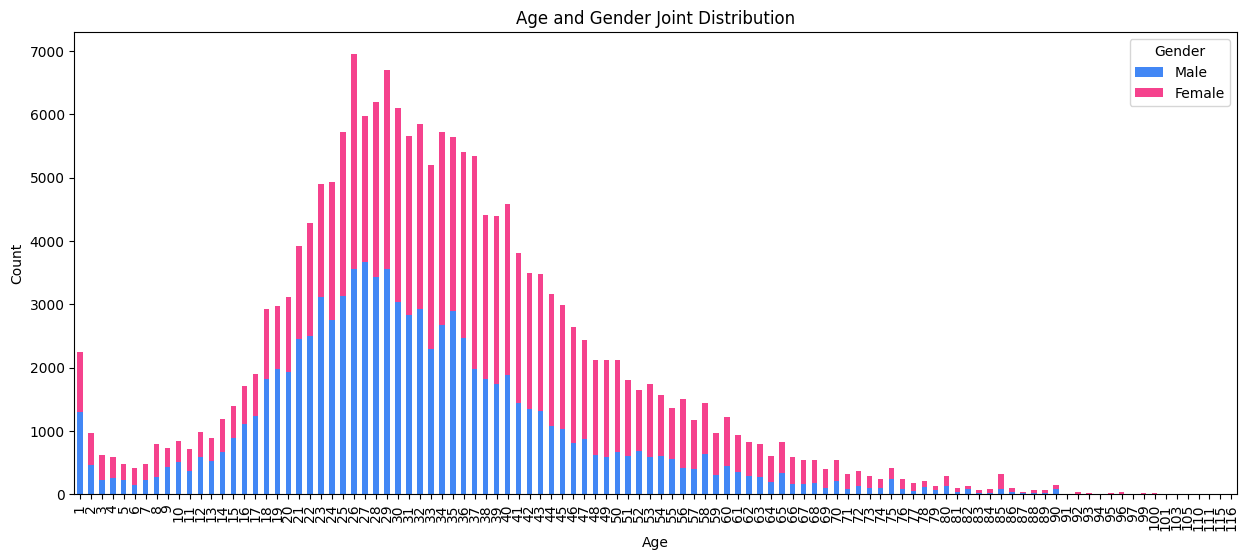

In [21]:

# Grouping the DataFrame 'df' by 'age' and 'gender' columns and counting the occurrences of each combination
age_groups = df.groupby(['age', 'gender']).size().unstack()

# Define custom colors for each gender category
colors = {0: '#4287f5', 1: '#f5428d'}

# Plotting the grouped data as a stacked bar chart with custom colors
age_groups.plot(kind='bar', stacked=True, figsize=(15, 6), color=[colors[col] for col in age_groups.columns])

# Adding a label to the x-axis
plt.xlabel('Age')

# Adding a label to the y-axis
plt.ylabel('Count')

# Adding a title to the plot
plt.title('Age and Gender Joint Distribution')

# Adding a legend to the plot with the title 'Gender'
plt.legend(title='Gender', labels=['Male', 'Female'])

# Displaying the plot
plt.show()

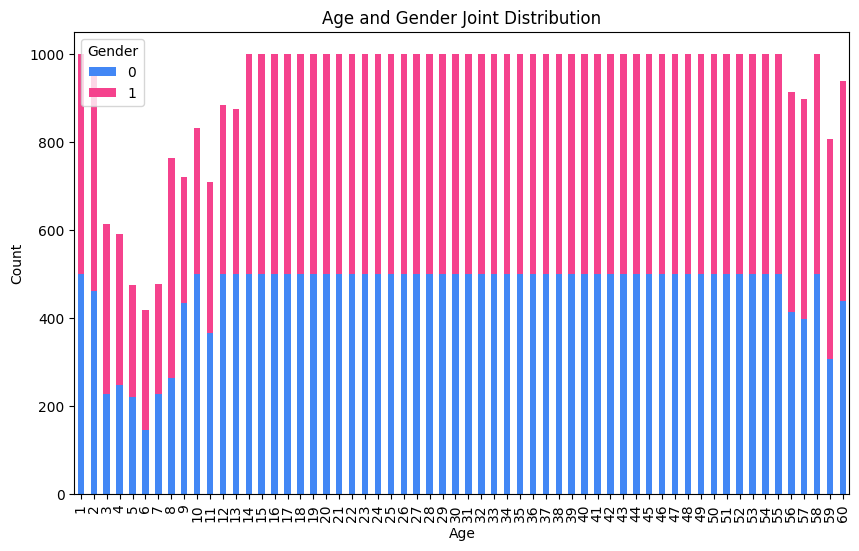

In [22]:
min_age = 0
max_age = 60
max_records_per_age_gender = 500

# Filter the DataFrame to keep only records within the desired age range
df_filtered = df[(df['age'] >= min_age) & (df['age'] <= max_age)]

# Calculate the target number of records for each gender
target_records_per_gender = df_filtered.groupby('gender').size().min() // 2

# Perform downsampling and create a new dataframe
downsampled_groups = df_filtered.groupby(['age', 'gender'], group_keys=False).apply(lambda group: group.sample(min(max_records_per_age_gender, len(group)), random_state=21))
df = downsampled_groups

# Group the downsampled dataframe
age_gender_groups = downsampled_groups.groupby(['age', 'gender']).size().unstack()

# Define custom colors for each gender category
colors = {0: '#4287f5', 1: '#f5428d'}

# Plotting
ax = age_gender_groups.plot(kind='bar', stacked=True, figsize=(10, 6), color=[colors[col] for col in age_gender_groups.columns])

# Adding labels and title
ax.set_xlabel('Age')
ax.set_ylabel('Count')
ax.set_title('Age and Gender Joint Distribution')
ax.legend(title='Gender')

# Displaying the plot
plt.show()

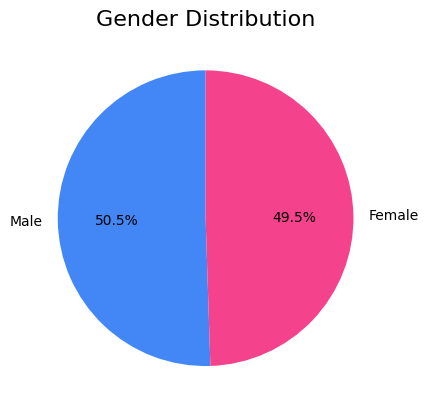

In [23]:
# Define the labels for the genders
gender_labels = ['Male', 'Female']

# Calculate the count of each gender category
gender_counts = df['gender'].value_counts()

# Define custom colors for the pie slices
colors = ['#4287f5', '#f5428d']

# Create a pie chart
plt.pie(gender_counts, labels=gender_labels, autopct='%1.1f%%', colors=colors, startangle=90)

# Add a title and adjust the font size
plt.title('Gender Distribution', fontsize=16)

# Display the chart
plt.show()

In [24]:
# Defining a function to return the class labels corresponding to the re-distributed 7 age-ranges.
def class_labels_reassign(age):
    if 1 <= age <= 12:
        return 0
    elif 13 <= age <= 18:
        return 1
    elif 19 <= age <= 30:
        return 2
    elif 31 <= age <= 42:
        return 3
    elif 43 <= age:
        return 4

#train_aug_df['target'] = train_aug_df['age'].map(class_labels_reassign)
#test_df['target'] = test_df['age'].map(class_labels_reassign)
df['target'] = df['age'].map(class_labels_reassign).astype(str)

In [25]:
# Shuffling the DataFrame 'df' and creating a new DataFrame 'df_trial' containing half of the shuffled data, rounding the number of rows if needed.
df_trial = shuffle(df)

# Splitting the shuffled DataFrame 'df_trial' into 'train' and 'val' DataFrames, with approximately 70% for training and 30% for validation.
train = df_trial[:round(df_trial.shape[0]*0.7)]
val = df_trial[round(df_trial.shape[0]*0.7):]

# Printing the number of rows and columns in the 'train' and 'val' DataFrames, respectively.
print(train.shape)
print(val.shape)

(39110, 12)
(16761, 12)


In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Defining an image data generator for data augmentation during training, which includes rescaling pixel values, random rotation within 25 degrees,
# random brightness adjustment between 0.7 and 1.3, random zooming up to 50%, and horizontal flipping of images.
train_datagen=ImageDataGenerator(rescale=1./255.,
                           rotation_range=20,
                           brightness_range=[0.7,1.3],
                           width_shift_range=0.1,
                           height_shift_range=0.1,
                           horizontal_flip=True)

# Creating an image data generator for the validation data with pixel value rescaling only.
valid_datagen=ImageDataGenerator(rescale=1./255.)

# Create augmented train and test datasets
train_aug_dataset = train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="D:/Users/ndhu2/Classes/Introduction to AI/Project/imdb_crop/",  # Assuming the full path is already in the 'path' column
    x_col='path',    # Column containing the filenames
    y_col='target',  # Column containing the target class labels
    target_size=(200, 200),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=128,
    shuffle=True,
    seed=42
)

test_dataset = valid_datagen.flow_from_dataframe(
    dataframe=val,
    directory="D:/Users/ndhu2/Classes/Introduction to AI/Project/imdb_crop/",  # Assuming the full path is already in the 'path' column
    x_col='path',    # Column containing the filenames
    y_col='target',  # Column containing the target class labels
    target_size=(200, 200),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=128,
    shuffle=False
)


Found 39110 validated image filenames belonging to 5 classes.
Found 16761 validated image filenames belonging to 5 classes.


In [ ]:

# Test with half of the data and just 5 epochs of training
# Define the hyperparameter search space
def build_model(hp):
    input_layer = Input(shape=(200, 200, 1))

    l2_reg_value = hp.Choice('l2_reg_value', values=[0.1, 0.01, 0.001])

    # Stack of Convolutional Blocks with increasing filters
    x = Conv2D(filters=32, kernel_size=3, activation='relu', kernel_regularizer=l2(l2_reg_value))(input_layer)
    #x = Conv2D(filters=32, kernel_size=3, activation='relu', kernel_regularizer=l2(l2_reg_value))(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=l2(l2_reg_value))(x)
    #x = Conv2D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=l2(l2_reg_value))(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=128, kernel_size=3, activation='relu', kernel_regularizer=l2(l2_reg_value))(x)
    #x = Conv2D(filters=128, kernel_size=3, activation='relu', kernel_regularizer=l2(l2_reg_value))(x)
    #x = Conv2D(filters=128, kernel_size=3, activation='relu', kernel_regularizer=l2(hp.Float('l2_reg_7', 1e-4, 0.1, sampling='log')))(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=256, kernel_size=3, activation='relu', kernel_regularizer=l2(l2_reg_value))(x)
    #x = Conv2D(filters=256, kernel_size=3, activation='relu', kernel_regularizer=l2(l2_reg_value))(x)
    #x = Conv2D(filters=256, kernel_size=3, activation='relu', kernel_regularizer=l2(hp.Float('l2_reg_7', 1e-4, 0.1, sampling='log')))(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization()(x)

    # GlobalAveragePooling2D layer before the Dense layers
    x = GlobalAveragePooling2D()(x)

    # Adding Dropout layer with a dropout rate sampled from the hyperparameter search space.
    x = Dropout(hp.Float('dropout_rate', 0.2, 0.4, step=0.1))(x)

    # Dense layers
    #x = Dense(256, activation='relu', kernel_regularizer=l2(l2_reg_value))(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(l2_reg_value))(x)
    
    # Output layer with 5 nodes (equal to the number of age intervals).
    output_layer = Dense(5, activation='softmax')(x)

    # Create the model
    model = Model(inputs=input_layer, outputs=output_layer)

    # Compile the model with a learning rate sampled from the hyperparameter search space.
    model.compile(loss='categorical_crossentropy', optimizer=Adam(hp.Choice('learning_rate', [1e-2, 1e-3])),
                  metrics=['accuracy'])

    return model


# Define the Keras Tuner RandomSearch
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=18,
    directory='D:/Users/ndhu2/Classes/Introduction to AI/Project/Models/M9_1/cnn_logs/tuning',
    project_name='age_estimation_tuning'
)

# Perform hyperparameter tuning with Random Search
tuner.search(train_aug_dataset, epochs=22, validation_data=test_dataset)

# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters(1)[0]

# Build and compile the final model with the best hyperparameters
final_model = build_model(best_hp)
final_model.compile(loss='categorical_crossentropy', optimizer=Adam(best_hp.get('learning_rate')), metrics=['accuracy'])

# Print the model summary
final_model.summary()

# Creating a TensorBoard callback object and saving it at the desired location.
tensorboard = TensorBoard(log_dir=f"D:/Users/ndhu2/Classes/Introduction to AI/Project/Models/M9_1/cnn_logs")

Trial 13 Complete [03h 55m 41s]
val_accuracy: 0.49786341190338135

Best val_accuracy So Far: 0.5540667772293091
Total elapsed time: 2d 13h 24m 27s

Search: Running Trial #14

Value             |Best Value So Far |Hyperparameter
0.001             |0.001             |l2_reg_value
0.2               |0.3               |dropout_rate
0.01              |0.001             |learning_rate

Epoch 1/22
252/252 [==============================] - 674s 3s/step - loss: 1.7847 - accuracy: 0.3374 - val_loss: 1.6611 - val_accuracy: 0.3316
Epoch 2/22
252/252 [==============================] - 766s 3s/step - loss: 1.5495 - accuracy: 0.3561 - val_loss: 1.7017 - val_accuracy: 0.2972
Epoch 3/22
252/252 [==============================] - 672s 3s/step - loss: 1.5399 - accuracy: 0.3619 - val_loss: 1.8075 - val_accuracy: 0.3193
Epoch 4/22
252/252 [==============================] - 671s 3s/step - loss: 1.5192 - accuracy: 0.3723 - val_loss: 2.6898 - val_accuracy: 0.1927
Epoch 5/22
252/252 [=========================

KeyboardInterrupt: 

In [27]:
# Defining the architecture of the convolutional neural network.

# Input layer
input_layer = Input(shape=(200, 200, 1))

# First convolutional layer with batch normalization and L2 regularization
x = Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(200, 200, 1),
           kernel_regularizer=l2(0.001))(input_layer)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Three Conv2D layers with filters increasing by a factor of 2 for every successive Conv2D layer.
x = Conv2D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=128, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=256, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=256, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=512, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)


# A GlobalAveragePooling2D layer before going into Dense layers below.
# GlobalAveragePooling2D layer gives no. of outputs equal to no. of filters in last Conv2D layer above (256).
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)

x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)

x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)


# Output layer with 5 nodes (equal to the number of classes).
output_layer = Dense(5, activation='softmax')(x)

# Create the model
final_cnn = Model(inputs=input_layer, outputs=output_layer)

# Compiling the model
final_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
final_cnn.summary()

# Creating a TensorBoard callback object and saving it at the desired location.
tensorboard = TensorBoard(log_dir=f"D:/Users/ndhu2/Classes/Introduction to AI/Project/Models/FM1/cnn_logs")


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 198, 198, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 198, 198, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 99, 99, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 97, 97, 64)        256   

In [48]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

# Define the step decay function for the learning rate
def step_decay(epoch):
    initial_lrate = 0.001  # Adjust the initial learning rate as needed
    drop = 0.5  # Adjust the drop factor as needed
    epochs_drop = 10  # Adjust the number of epochs for learning rate drop as needed
    lrate = initial_lrate * (drop ** (epoch // epochs_drop))
    return lrate

# Creating an EarlyStopping callback object
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Creating a ModelCheckpoint callback object to save the model according to the value of val_accuracy.
checkpoint = ModelCheckpoint(filepath=f"D:/Users/ndhu2/Classes/Introduction to AI/Project/Models/FM1/cnn_logs/age_model_checkpoint.h5",
                             monitor='val_accuracy',
                             save_best_only=True,
                             save_weights_only=False,
                             verbose=1
                            )

# Creating a LearningRateScheduler callback object
lr_scheduler = LearningRateScheduler(step_decay)

# Train the model with data augmentation and callbacks
final_cnn_history = final_cnn.fit(
    train_aug_dataset,
    validation_data=test_dataset,  # Use the original test_dataset for validation
    epochs=60,
    callbacks=[tensorboard, checkpoint, early_stopping, lr_scheduler]
)

Epoch 1/60
306/306 [==============================] - ETA: 0s - loss: 2.6670 - accuracy: 0.3723
Epoch 1: val_accuracy improved from -inf to 0.33817, saving model to D:/Users/ndhu2/Classes/Introduction to AI/Project/Models/FM2/cnn_logs\age_model_checkpoint.h5
306/306 [==============================] - 1148s 4s/step - loss: 2.6670 - accuracy: 0.3723 - val_loss: 2.4367 - val_accuracy: 0.3382 - lr: 0.0010
Epoch 2/60


c:\Users\ndhu2\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


306/306 [==============================] - ETA: 0s - loss: 2.0021 - accuracy: 0.4368
Epoch 2: val_accuracy improved from 0.33817 to 0.42784, saving model to D:/Users/ndhu2/Classes/Introduction to AI/Project/Models/FM2/cnn_logs\age_model_checkpoint.h5
306/306 [==============================] - 1204s 4s/step - loss: 2.0021 - accuracy: 0.4368 - val_loss: 1.8731 - val_accuracy: 0.4278 - lr: 0.0010
Epoch 3/60
306/306 [==============================] - ETA: 0s - loss: 1.6644 - accuracy: 0.4713
Epoch 3: val_accuracy improved from 0.42784 to 0.44651, saving model to D:/Users/ndhu2/Classes/Introduction to AI/Project/Models/FM2/cnn_logs\age_model_checkpoint.h5
306/306 [==============================] - 1168s 4s/step - loss: 1.6644 - accuracy: 0.4713 - val_loss: 1.6610 - val_accuracy: 0.4465 - lr: 0.0010
Epoch 4/60
306/306 [==============================] - ETA: 0s - loss: 1.5154 - accuracy: 0.5069
Epoch 4: val_accuracy improved from 0.44651 to 0.46346, saving model to D:/Users/ndhu2/Classes/Intr

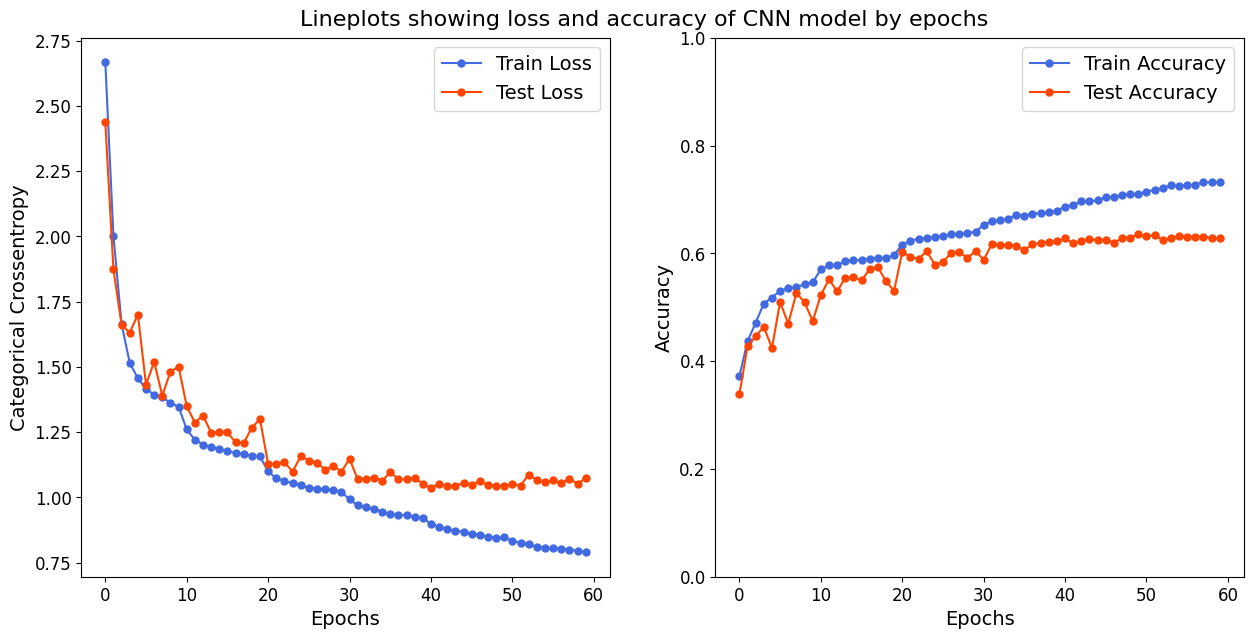

In [ ]:
# Checking the train and test loss and accuracy values from the neural network above.
train_loss = final_cnn_history.history['loss']
test_loss = final_cnn_history.history['val_loss']
train_accuracy = final_cnn_history.history['accuracy']
test_accuracy = final_cnn_history.history['val_accuracy']



# Plotting a line chart to visualize the loss and accuracy values by epochs.
fig, ax = plt.subplots(ncols=2, figsize=(15,7))
ax = ax.ravel()
ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss, label='Test Loss', color = 'orangered', marker='o', markersize=5)
ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)
ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)
ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy, label='Test Accuracy', color='orangered', marker='o', markersize=5)
ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)
ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)
ax[1].set_ylim(0, 1)


fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of CNN model by epochs", fontsize=16)


# Exporting plot image in PNG format.
plt.savefig('D:/Users/ndhu2/Classes/Introduction to AI/Project/Models/FM1/cnn_logs/final_cnn_loss_accuracy.png', bbox_inches='tight')


131/131 [==============================] - 83s 628ms/step - loss: 1.0425 - accuracy: 0.6350
CNN model loss 		= 1.043
CNN model accuracy 	= 0.635


c:\Users\ndhu2\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


131/131 [==============================] - 85s 651ms/step
Normalized confusion matrix


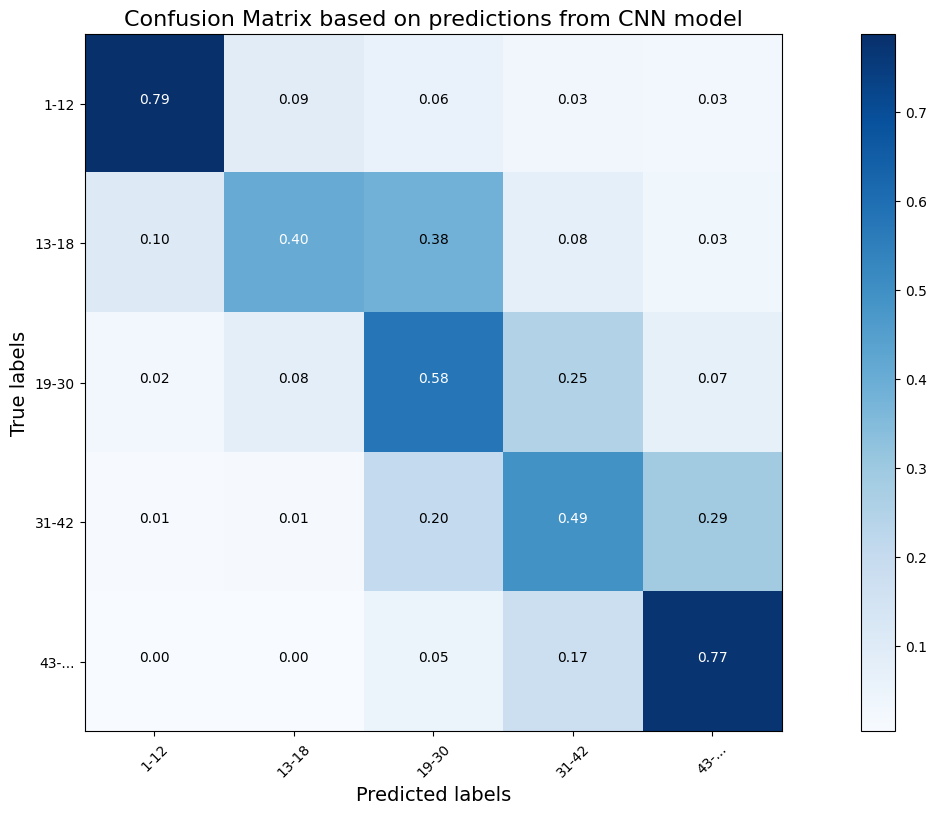

In [66]:
# Evaluating the model on test dataset.
final_cnn_score = final_cnn.evaluate(test_dataset, verbose=1)
# Printing the relevant score summary.
final_cnn_labels = final_cnn.metrics_names
print(f'CNN model {final_cnn_labels[0]} \t\t= {round(final_cnn_score[0], 3)}')
print(f'CNN model {final_cnn_labels[1]} \t= {round(final_cnn_score[1], 3)}')

# Saving the model as a keras file for possible use later.
final_cnn.save(f"D:/Users/ndhu2/Classes/Introduction to AI/Project/Models/FM1/age_model_acc_{round(final_cnn_score[1], 3)}.h5", save_format='h5')

# Generating predictions from the model above.
final_cnn_pred = final_cnn.predict(test_dataset)
final_cnn_pred = final_cnn_pred.argmax(axis=-1)
# Generating a confusion matrix based on above predictions.
test_labels_list = list(val['target'].astype('int64'))
conf_mat = confusion_matrix(test_labels_list, final_cnn_pred)

# Defining a function to plot the confusion matrix in a grid for easier visualization.
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', export_as='confusion_matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    # print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True labels', fontsize=14)
    plt.xlabel('Predicted labels', fontsize=14)
    # Exporting plot image in PNG format.
    plt.savefig(f'D:/Users/ndhu2/Classes/Introduction to AI/Project/Models/FM1/cnn_logs/{export_as}.png', bbox_inches='tight');

# Plotting the confusion matrix using the function defined above.
cm_plot_labels = ['1-12', '13-18', '19-30', '31-42', '43-...']

plt.figure(figsize=(16,8))
plot_confusion_matrix(conf_mat, cm_plot_labels, normalize=True,
                      title="Confusion Matrix based on predictions from CNN model",
                      export_as="final_cnn_conf_mat_norm"
                     )
plt.show()